In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    
    

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


In [2]:
shape_path = '../../datasets/FFHQ/raw_bfm_shape/'
file_indices = []
for fname in os.listdir(shape_path):
    if fname.endswith('.npy'):
        file_indices.append(fname.split('.')[0])
shape_path += '{}.npy'

ffhq_meanshape = np.load('../ffhq_meanshape.npy')



In [3]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    #'S_rest':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


In [4]:
import math
bfm_68_landmarks = bfm['keypoints'][0] # mapping between 68 landmarks and their bfm vertices

def landmark_2_vertex(landmark_idx):
    """convert landmark (1~68) to corresponding bfm vertex index"""
    return bfm_68_landmarks[landmark_idx-1]

def bounding_box_height(shape, vertices):
    y_max = np.max(shape[0, vertices, 1])
    y_min = np.min(shape[0, vertices, 1])
    height = y_max - y_min
    return height

def bounding_box_width(shape, vertices):
    x_max = np.max(shape[0, vertices, 0])
    x_min = np.min(shape[0, vertices, 0])
    width = x_max - x_min
    return width


def euclidean_distance(shape, v1, v2):
    p1 = shape[0, v1, :]
    p2 = shape[0, v2, :]
    pp = np.square(p1 - p2)    
    return math.sqrt(pp[0] + pp[1] + pp[2])






def pupils_distance(ffhq_meanshape, shape):
    """ Distance between the centers of two pupils """
    v1 = 4410
    v2 = 11875
    width_mean = abs(ffhq_meanshape[0, v1, 0] - ffhq_meanshape[0, v2, 0])
    width = abs(shape[0, v1, 0] - shape[0, v2, 0])
    return width - width_mean

def eye_height(ffhq_meanshape, shape):
    """ Palpebral fissure height vertically from pupillary center """
    v1 = 4404
    v2 = 4286
    height_mean = abs(ffhq_meanshape[0, v1, 1] - ffhq_meanshape[0, v2, 1])
    height = abs(shape[0, v1, 1] - shape[0, v2, 1])
    return height - height_mean

def canthus_distance(ffhq_meanshape, shape):
    """ Distance between medial canthus and lateral canthus """
    v1 = 5958 # left-eye medial canthus
    v2 = 2346 # left-eye lateral canthus
    distance_mean = euclidean_distance(ffhq_meanshape, v1, v2)
    distance = euclidean_distance(shape, v1, v2)
    return distance - distance_mean

def medial_canthus_y(ffhq_meanshape, shape):
    """ medial canthus up/down """
    v1 = 5958 # left-eye medial canthus
    y_offset = shape[0, v1, 1] - ffhq_meanshape[0, v1, 1]
    return y_offset

def lateral_canthus_y(ffhq_meanshape, shape):
    """ lateral canthus up/down """
    v1 = 2346 # left-eye lateral canthus
    y_offset = shape[0, v1, 1] - ffhq_meanshape[0, v1, 1]
    return y_offset






In [5]:
"""
Measure the shapes and record in a matrix
"""
measurements = np.zeros([len(file_indices), 5])

for i in tqdm(range(len(file_indices))):
    file_idx = file_indices[i]
    shape = np.load(shape_path.format(file_idx))
    
    measurements[i, 0] = pupils_distance(ffhq_meanshape, shape)
    measurements[i, 1] = eye_height(ffhq_meanshape, shape)
    measurements[i, 2] = canthus_distance(ffhq_meanshape, shape)
    measurements[i, 3] = medial_canthus_y(ffhq_meanshape, shape)
    measurements[i, 4] = lateral_canthus_y(ffhq_meanshape, shape)
  



100%|███████████████████████████████████████████████████████████████████████████| 68422/68422 [09:50<00:00, 115.95it/s]


   pupils_distance  eye_height  canthus_distance  medial_canthus_y  \
0         0.002660   -0.007949         -0.003181         -0.052944   
1        -0.030134   -0.010071         -0.009686         -0.003199   
2         0.010204    0.011438          0.008273         -0.027428   
3        -0.007251    0.009367         -0.011476         -0.024157   
4        -0.002400    0.000172         -0.001313          0.011982   

   lateral_canthus_y  
0          -0.056969  
1          -0.015040  
2          -0.009739  
3          -0.010830  
4           0.005105  


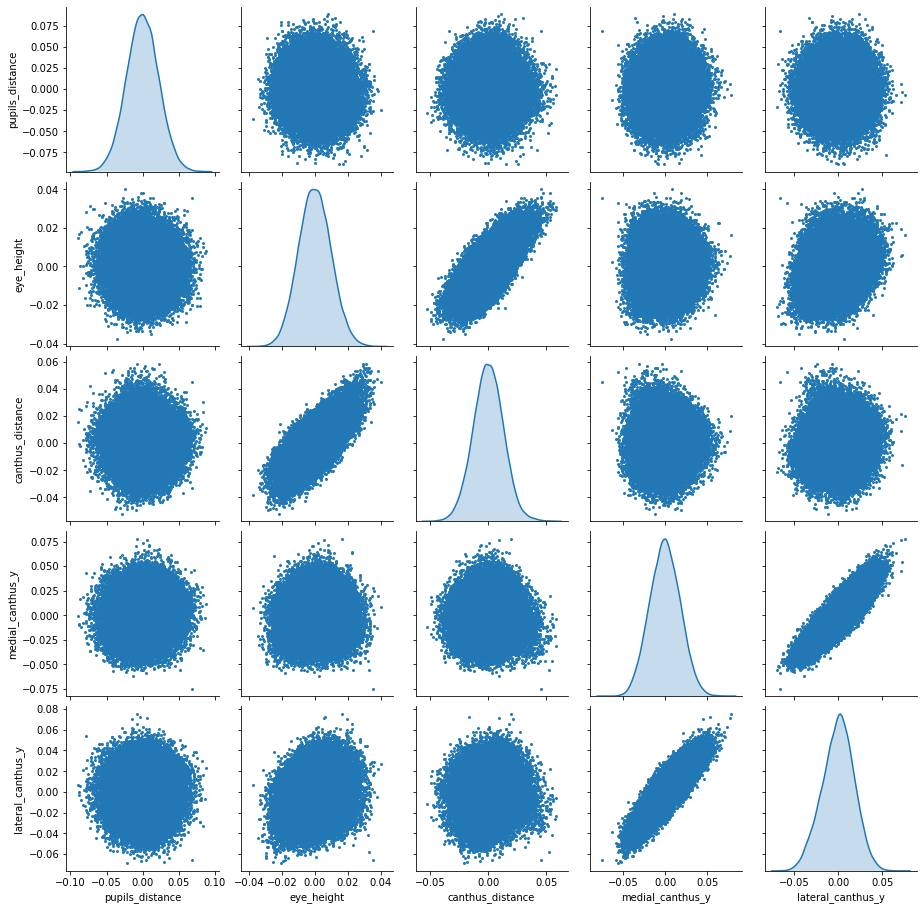

In [6]:
"""
Visualize the data
"""
import seaborn as sns
import pandas as pd

measurement_names = [
    'pupils_distance',
    'eye_height',
    'canthus_distance',
    'medial_canthus_y',
    'lateral_canthus_y'
]
    


d = {
    measurement_names[0]: measurements[:, 0],
    measurement_names[1]: measurements[:, 1],
    measurement_names[2]: measurements[:, 2],
    measurement_names[3]: measurements[:, 3],
    measurement_names[4]: measurements[:, 4]
}

df = pd.DataFrame(data=d)
print(df.head())

_ = sns.pairplot(df, 
                 plot_kws=dict(marker=".", linewidth=0.01), 
                 diag_kind="kde")



In [7]:
""" Save the data matrix """

#np.save('./cache/measurements/{}.npy'.format('S_eyes'), measurements)

1.0